# - Scenario run: keeping observed shade values in the whole reach and add 25ft veg buffer to each 500km land cover sheet
- Find the top 10 reaches from this scenario and add that land cover to a scenario - report the change in hours or days above july thermal maximum


In [172]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
from scipy.integrate import simps

import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

# Start of Heatsource scenario iterations

## reading in source files (some of these are legacy from old scripts that code relies on, like notoposhade, need to fix)

In [175]:
observed_source_folder = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\july_monthly_extended'
bankbuffer_source_folder = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\observedshadeincrease_extended'

In [177]:
notopo_shade_df = pd.read_csv(os.path.join(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\extending_model\notopo_july_monthly_extended', 'outputs', 'Shade.csv'), skiprows=6,
         usecols=range(1, 185))
notopo_shade_df.columns = [float(col) for col in notopo_shade_df.columns]
obs_clip_day = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]
obs_clip_day["datetime"] = pd.to_datetime(obs_clip_day["datetime"])
obs_clip_day = obs_clip_day.set_index('datetime')

obs_clip_mean = obs_clip_day.resample('D').mean()
notopo_shade_df.index = obs_clip_mean.index
notopo_shade_df = notopo_shade_df.mean()
notopo_shade_df = pd.DataFrame(notopo_shade_df)
notopo_shade_df = notopo_shade_df.reset_index()
notopo_shade_df.rename(columns={'index': 'NODE_ID', 0 : 'July Shade'}, inplace=True)

notopo_shade_df[(notopo_shade_df['NODE_ID'] <= 18.3) & (notopo_shade_df['NODE_ID']>=10)]
notopo_shade_df

,NODE_ID,July Shade
0,27.2,0.447790
1,27.1,0.344123
2,27.0,0.362777
3,26.9,0.063716
4,26.8,0.064461
...,...,...
179,9.3,0.043368
180,9.2,0.083445
181,9.1,0.165855
182,9.0,0.142884


In [221]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(observed_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
#obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

# Heatsource iteration:
- this code reads in the observed baseline model, and iterates through 500m reaches adding shade to the existing landcover data 
- can take a while to run if doing so on monthly models

In [179]:
## Remove trees in 500m reach, narrow if the node isnt previously forested

landcover = pd.read_csv(os.path.join(observed_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(observed_source_folder, 'inputs\WFK23_morphology.csv'))
forestmorphology = pd.read_csv(os.path.join(bankbuffer_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(observed_source_folder, 'inputs\WFK23_lcdata_notopo.csv'))
#grasslandcover = pd.read_csv(os.path.join(grass_source_folder, 'inputs\WFK23_lcdata.csv'))
forestlandcover = pd.read_csv(os.path.join(bankbuffer_source_folder, 'inputs\WFK23_lcdata.csv'))

changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    #print("km_start:", km_start)
    landcover_km = landcover.copy()# Create a copy of landcover DataFrame
    morphology_km = morphology.copy()
    forestlandcover_km = forestlandcover.copy()# Create a copy of landcover DataFrame
# Create a copy of morphology DataFrame
    if km_start == 8.9:
        break
    if km_start == 27.2:
        km_end = 27
        # Defining new folders to write scenario outputs to
        original_folder_path = observed_source_folder
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\observedbaseline_shading_monthly\reach_27.2'
        shutil.copytree(original_folder_path, new_folder_path) 

        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        

        # Assign shade value to specific range of columns for the current kilometer stretch (using shade without topo)
        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = forestlandcover.loc[index, forestlandcover.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            
            morphology_km.loc[index,morphology_km.columns[5]] = forestmorphology.loc[index,forestmorphology.columns[5]]
            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)

        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        #Widen nodes where shade is increase
        
        # morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]] = (morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]])*1.5
        # morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
        
        #running heatsource
#         os.chdir(new_folder_path)
#         subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        continue
    # Check if 'STREAM_KM' is a float and ends with '.0'
    
    if isinstance(km_start, float) and km_start % .5 == 0:
        landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        morphology_km = morphology.copy()
        forestlandcover_km = forestlandcover.copy()# Create a copy of landcover DataFrame

        print(km_start)
        #print('true')
        # if km_start == 18.0:
        #     continue
        km_end = km_start - .5  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = observed_source_folder
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = f'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\observedbaseline_shading_monthly\\reach_{km_start}'
        shutil.copytree(original_folder_path, new_folder_path) 

        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)
        #filter df to only get rows within the 500m reach
        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>km_end)]
        print(km_start)
        changed_nodes[km_start] = []
        #loop through each row in reach and change landcover and morphology to forest
        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = forestlandcover.loc[index, forestlandcover.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            # if reach_shade.loc[index]['July Shade'] < .2:
            #     print('widening @: ', index)
            #     #narrow forested nodes

            # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
            morphology_km.loc[index,morphology_km.columns[5]] = forestmorphology.loc[index,forestmorphology.columns[5]]

            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)

        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    


27.2
27.0
27.0
26.5
26.5
26.0
26.0
25.5
25.5
25.0
25.0
24.5
24.5
24.0
24.0
23.5
23.5
23.0
23.0
22.5
22.5
22.0
22.0
21.5
21.5
21.0
21.0
20.5
20.5
20.0
20.0
19.5
19.5
19.0
19.0
18.5
18.5
18.0
18.0
17.5
17.5
17.0
17.0
16.5
16.5
16.0
16.0
15.5
15.5
15.0
15.0
14.5
14.5
14.0
14.0
13.5
13.5
13.0
13.0
12.5
12.5
12.0
12.0
11.5
11.5
11.0
11.0
10.5
10.5
10.0
10.0
9.5
9.5
9.0
9.0


## Plotting heatsource results
- plots the results of each 500m reach vs the baseline
- adds attributes about the reach to multiple dictionaries (width, velocity, existing shade, post-scenario shade, change in shade) for use in regression analysis


In [92]:
azimuth = pd.read_csv('Channel_azimuth.csv')
azimuth

,STREAM_KM,Azm,GRADIENT
0,27.2,163.828943,0.006927
1,27.1,179.872523,0.004156
2,27.0,165.636125,0.009049
3,26.9,160.647484,0.007716
4,26.8,167.489778,0.010185
...,...,...,...
179,9.3,52.881381,0.001515
180,9.2,75.681361,0.001559
181,9.1,134.743087,0.003025
182,9.0,179.641738,0.004710


In [116]:
(upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp']

0.007828403540903523

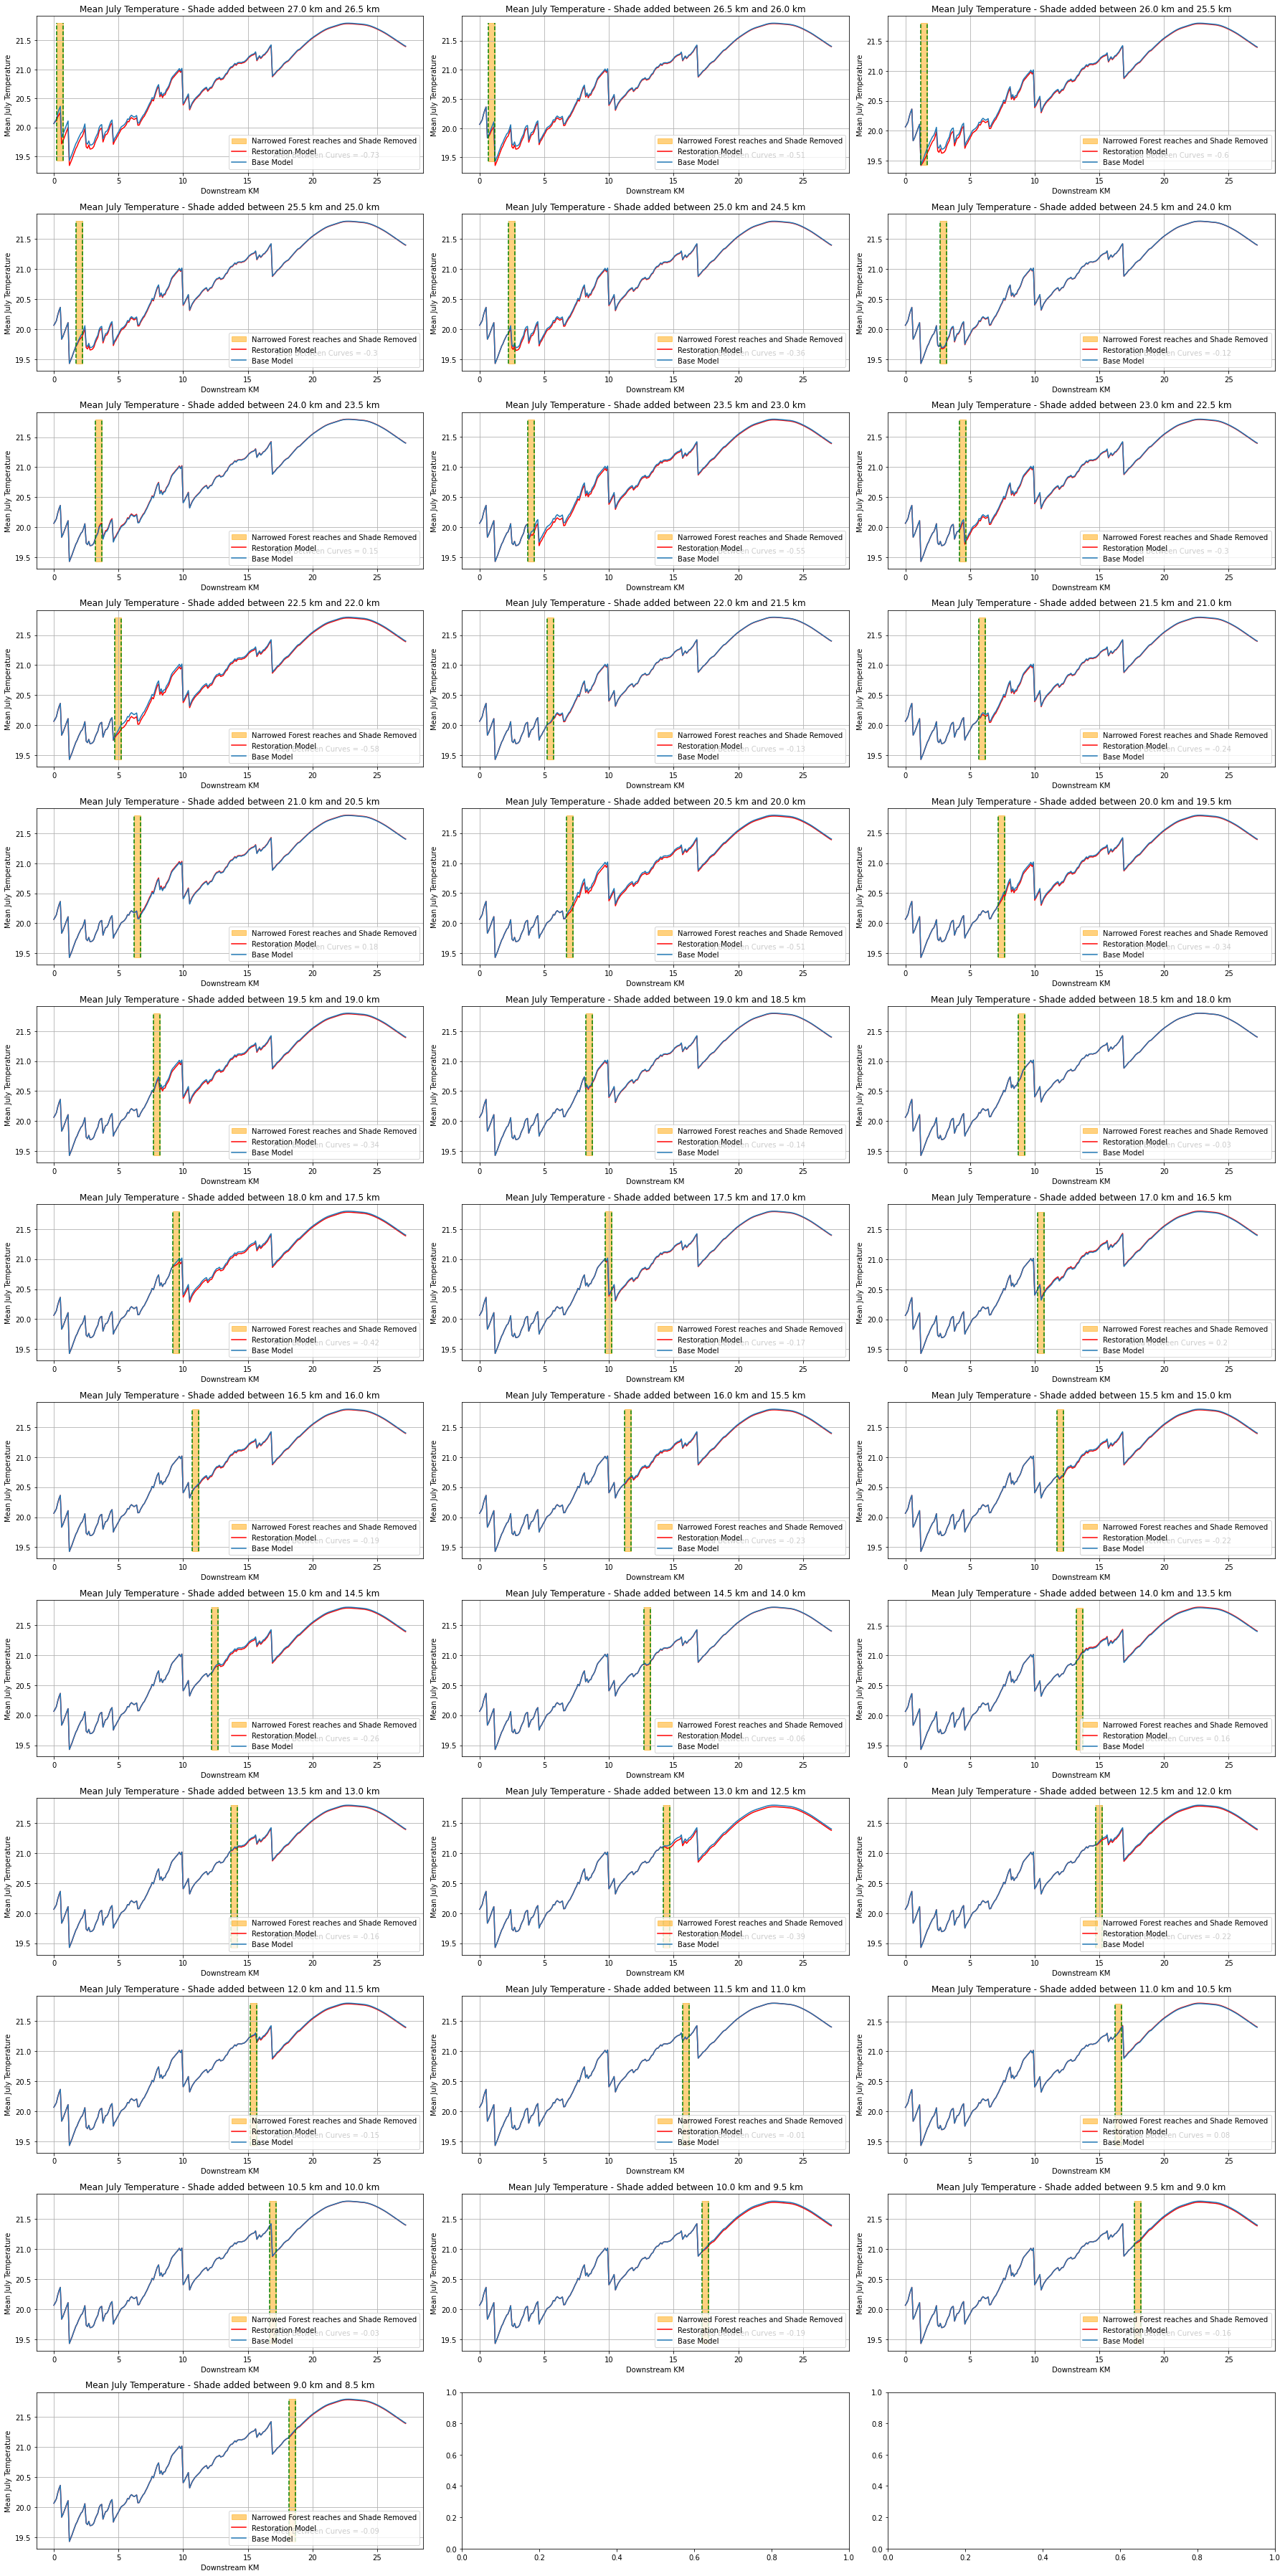

In [201]:
values = [27-(x / 2) for x in range(0, 37)]

obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(observed_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled_mean = upstreamconstant_df.resample('D').mean()

upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
# upstreamconstant_modeled = upstreamconstant_df.resample('D').sum()

upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

obs_rolling_avg = upstreamconstant_modeled_mean.rolling(window=7).max()
obs_max_mwat = obs_rolling_avg.max()
upstreamconstant_modeled['Max MWAT'] = obs_max_mwat.values

#base shade scenario

base_shade_df = pd.read_csv(os.path.join(observed_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 274))
base_hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive
base_shade_df.columns = [float(col) for col in base_shade_df.columns]
base_shade_df.index = daily_index
# base_shade_df.index = obs_clip.index

base_shade = base_shade_df.mean()
base_shade = pd.DataFrame(base_shade)
base_shade = base_shade.reset_index()
base_shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)

#discts to hold differneces between scenarios
effectiveness_difference = {}
reach_shade_base = {}
reach_shade_scenario = {}
reach_shade_change = {}
reach_velocity = {}
reach_width = {}
reach_depth = {}
reach_widthdepth = {}
reach_azimuth = {}
reach_gradient = {}
count = 0
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder =  f'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\observedbaseline_shading_monthly\\reach_{i}'
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        # mean july temperature summary
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        sim__rolling_avg = mean_daily_modeled.rolling(window=7).max()
        sim_max_mwat = sim__rolling_avg.max()
        mean_july_modeled['Max MWAT'] = sim_max_mwat.values
        # mwat = mean_daily_modeled.rolling(window=7).max()
        # mwat = mwat.max()
        # mwat = pd.DataFrame(mwat)
        # mean_july_modeled = pd.merge(mean_july_modeled, mwat[0], left_on='NODE_ID', right_index = True, how='left')
        # mean_july_modeled.rename(columns={0: 'Max MWAT'}, inplace=True) 
        
        #saving reach effectiveness
        # difference = mean_july_modeled['Mean July Temp'] - upstreamconstant_modeled['Mean July Temp']
        # norm_difference = difference/km_start
        # norm_difference = norm_difference.values.sum()
        # norm_effectiveness_difference[km_start] = norm_difference
        # effectiveness_difference[km_start] = difference.values.sum()
        
        #doing integration
        x = mean_july_modeled['NODE_ID']
        y1 = mean_july_modeled['Mean July Temp']
        y2 = upstreamconstant_modeled['Mean July Temp']

        
        
        
        
        # Compute absolute difference between the curves
        abs_diff = np.abs(y1 - y2)

        # Use Simpson's rule for numerical integration
        area = simps(abs_diff, x)
        #changing sign of degree kilomters to be negative or positive based on if its cooling (negative) or warming (positive) from restoration
        if (upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp'] <= 0:
            area = area*-1
        
        effectiveness_difference[km_start] = area
        
        #getting effective shade values
        scenario_shade_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 274))
        # hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive
        #         hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive

        scenario_shade_df.columns = [float(col) for col in scenario_shade_df.columns]
        scenario_shade_df.index = daily_index
        shade = scenario_shade_df.mean()
        shade = pd.DataFrame(shade)
        shade = shade.reset_index()
        shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)
        reach = shade[(shade['NODE_ID'] <= km_start) & (shade['NODE_ID'] >=km_end)]
        base_reach = base_shade[(base_shade['NODE_ID'] <= km_start) & (base_shade['NODE_ID'] >=km_end)]
        
        #compare base shade to scenario shade 
        reach_percent_increase = (base_reach - reach)/base_reach
        reach_difference = reach - base_reach

        reach_mean_percent_increase = reach_percent_increase['Effective Shade %'].mean()    
        #reach_shade[km_start] = reach_mean_percent_increase
        reach_shade_base[km_start] = base_reach['Effective Shade %'].mean()
        reach_shade_scenario[km_start] = reach['Effective Shade %'].mean()
        reach_shade_change[km_start] = reach_difference['Effective Shade %'].mean()

        #get reach azimuth
        azimuth = pd.read_csv(r'D:\Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/results/Channel_azimuth.csv')
        azimuth_reach = azimuth[(azimuth['STREAM_KM'] <= km_start) & (azimuth['STREAM_KM'] >=km_end)]
        azimuth_reach_mean = azimuth_reach['Azm'].mean()
        reach_azimuth[km_start] = abs(azimuth_reach_mean-180)
        
        #get reach gradient 
        # gradient = pd.read_csv('Channel_azimuth.csv')
        gradient = pd.read_csv(r'D:\Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/results/Channel_azimuth.csv')

        gradient_reach = gradient[(gradient['STREAM_KM'] <= km_start) & (gradient['STREAM_KM'] >=km_end)]
        gradient_reach_mean = gradient_reach['GRADIENT'].mean()
        reach_gradient[km_start] = gradient_reach_mean

        #getting mean velocity
        velocity = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Vel.csv'), skiprows=6, usecols=range(1, 274))
        velocity.columns = [float(col) for col in velocity.columns]
        sim_velocity = velocity.mean()#.to_numpy()
        sim_velocity = pd.DataFrame(sim_velocity)
        sim_velocity = sim_velocity.reset_index()
        sim_velocity.rename(columns={'index': 'NODE_ID', 0 : 'Velocity'}, inplace=True)
        velocity_reach = sim_velocity[(sim_velocity['NODE_ID'] <= km_start) & (sim_velocity['NODE_ID'] >=km_end)]
        reach_mean_velocity = velocity_reach['Velocity'].mean()
        reach_velocity[km_start] = reach_mean_velocity
        
        #Getting Width
        sim_width = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 274))
        sim_width.columns = [float(col) for col in sim_width.columns]
        sim_width = sim_width.iloc[0]#.to_numpy()
        sim_width = pd.DataFrame(sim_width)
        sim_width = sim_width.reset_index()
        sim_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)
        sim_width = sim_width[(sim_width['NODE_ID'] <= km_start) & (sim_width['NODE_ID'] >=km_end)]
        reach_width[km_start] = sim_width['Width'].mean()
        
        #getting depth
        sim_depth = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_DA.csv'), skiprows=6, usecols=range(1, 274))
        sim_depth.columns = [float(col) for col in sim_depth.columns]
        sim_depth = sim_depth.iloc[0]#.to_numpy()
        sim_depth = pd.DataFrame(sim_depth)
        sim_depth = sim_depth.reset_index()
        sim_depth.rename(columns={'index': 'NODE_ID', 0 : f'Depth'}, inplace=True)
        sim_depth = sim_depth[(sim_depth['NODE_ID'] <= km_start) & (sim_depth['NODE_ID'] >=km_end)]
        reach_depth[km_start] = sim_depth['Depth'].mean()
        #width:depth
        reach_widthdepth[km_start] = (sim_width['Width'].mean()/sim_depth['Depth'].mean())
        
        
        #plotting
        # Create a new figure with a 3x3 grid of subplots

        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([27.2 - km_start, 27.2 - km_end], upstreamconstant_modeled['Mean July Temp'].min(),upstreamconstant_modeled['Mean July Temp'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(27.2-mean_july_modeled['NODE_ID'], mean_july_modeled['Mean July Temp'], label=f'Restoration Model', color = 'red')
        axes[count-1].plot(27.2-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Mean July Temp'], label='Base Model')
        axes[count-1].set_title(f'Mean July Temperature - Shade added between {km_start} km and {km_end} km')
        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Mean July Temperature')  # Replace 'Y Label' with appropriate label
        axes[count-1].text(0.75, 0.1, f'Area Between Curves = {round(area,2)}', horizontalalignment='center', transform=axes[count-1].transAxes)

        # Plot the shade data on the second y-axis
        # axes[count-1] = axes[count-1].twinx()
        # axes[count-1].plot(27.2-shade.index, shade[0], label='Mean Solar Radiation Flux \n At Stream Surface', color='red', alpha = .5)
        # axes[count-1].set_ylabel('Mean Solar Radiation Flux \n At Stream Surface (W/m2)', color = 'red')
        # axes[count-1].tick_params(axis='y', colors='red')

        axes[count-1].vlines([27.2 - km_start, 27.2 - km_end], ymin = upstreamconstant_modeled['Mean July Temp'].min(), ymax = upstreamconstant_modeled['Mean July Temp'].max(),color = 'green', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'lower right')

        #axes[count-1].legend(loc = 'lower right')
        # axes[count-1].set_xlim([18.3 - km_end-2, 18.3 - km_start+2 ])


    #plt.show()
    #add vertical line where shade is added              
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
#new_folder_name = f"folder_{km_start}"

# Adding scenario results to dataframes
- adds attributes from reach level scenarios ot dataframe
- joins the dataframe to a shapefile of all the reaches

In [203]:
#read in 500m reaches shapefile
nodes = gpd.read_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/shp/restoration_reaches500m.shp')
nodes

reach_shadescenario_dict = pd.DataFrame(list(reach_shade_scenario.items()), columns=['Reach Start KM', 'SR Scenario'])
reach_shadebase_dict = pd.DataFrame(list(reach_shade_base.items()), columns=['Reach Start KM', 'SR Baseline'])
reach_velocity_dict = pd.DataFrame(list(reach_velocity.items()), columns=['Reach Start KM', 'Velocity'])
reach_width_dict = pd.DataFrame(list(reach_width.items()), columns=['Reach Start KM', 'Width'])
reach_depth_dict = pd.DataFrame(list(reach_depth.items()), columns=['Reach Start KM', 'Depth'])
reach_widthdepth_dict = pd.DataFrame(list(reach_widthdepth.items()), columns=['Reach Start KM', 'Width:Depth'])
reach_shadedif_dict = pd.DataFrame(list(reach_shade_change.items()), columns=['Reach Start KM', 'SR Difference'])
reach_azimuth_dict = pd.DataFrame(list(reach_azimuth.items()), columns=['Reach Start KM', 'Mean Azimuth'])
reach_gradient_dict = pd.DataFrame(list(reach_gradient.items()), columns=['Reach Start KM', 'Gradient'])



#creating df to add to 
dif_df_dict = pd.DataFrame(list(effectiveness_difference.items()), columns=['Reach Start KM', 'Degree Kilometers'])

#adding data from scenarios
dif_df_dict['Model Start KM'] = dif_df_dict['Reach Start KM']
dif_df_dict['Reach Start KM'] = dif_df_dict['Reach Start KM']-9
dif_df_dict['Mean velocity'] = reach_velocity_dict['Velocity']
dif_df_dict['Mean Azimuth'] = reach_azimuth_dict['Mean Azimuth']
dif_df_dict['Width'] = reach_width_dict['Width']
dif_df_dict['Depth'] = reach_depth_dict['Depth']
dif_df_dict['Width:Depth'] = reach_widthdepth_dict['Width:Depth']
dif_df_dict['Change in SR'] = reach_shadedif_dict['SR Difference']*100
dif_df_dict['Baseline SR'] = reach_shadebase_dict['SR Baseline']*100
dif_df_dict['Scenario SR'] = reach_shadescenario_dict['SR Scenario']*100
dif_df_dict['absolute DK'] = dif_df_dict['Degree Kilometers']
dif_df_dict['Gradient'] = reach_gradient_dict['Gradient']

dif_df_dict['row'] = dif_df_dict.index+1


dif_df_dict.drop(dif_df_dict.tail(1).index, inplace=True)
dif_df_dict['Distance Downstream'] = 18.0 - dif_df_dict['Reach Start KM']
dif_df_dict = dif_df_dict.sort_values('Degree Kilometers')
dif_df_dict.reset_index(drop=True, inplace=True)
dif_df_dict.index.name = 'Effectiveness Rank'
dif_df_dict.reset_index(inplace=True)
dif_df_dict.index += 1
merged_gdf_dif = pd.merge(nodes, dif_df_dict[['Reach Start KM','Degree Kilometers', 'row','absolute DK','Effectiveness Rank', 'Width', 'Baseline SR', 'Change in SR', 'Mean velocity', 'Mean Azimuth']], left_on='row', right_on = 'row', how='left')
#merged_gdf_dif.drop(merged_gdf_dif['row'], axis=0, errors='ignore')

#merged_gdf_dif.to_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/extending_model/ranking_treeremoval.shp')
dif_df_dict.sort_values(by = 'Effectiveness Rank')

,Effectiveness Rank,Reach Start KM,Degree Kilometers,Model Start KM,Mean velocity,Mean Azimuth,Width,Depth,Width:Depth,Change in SR,Baseline SR,Scenario SR,absolute DK,Gradient,row,Distance Downstream
1,0,18.0,-0.729574,27.0,0.187000,25.251616,9.207167,0.229400,40.135862,20.575430,21.006452,41.581882,-0.729574,0.004892,1,0.0
2,1,17.0,-0.598881,26.0,0.141600,8.798597,10.482400,0.323783,32.374736,21.814086,6.895699,28.709785,-0.598881,0.001010,3,1.0
3,2,13.5,-0.584615,22.5,0.213200,51.823624,12.106217,0.271917,44.521790,17.220591,16.193925,33.414516,-0.584615,0.002953,10,4.5
4,3,14.5,-0.547238,23.5,0.200567,8.212636,15.266350,0.194800,78.369353,12.159731,28.564946,40.724677,-0.547238,0.004856,8,3.5
5,4,11.5,-0.509052,20.5,0.170133,6.466463,13.484383,0.410650,32.836682,15.745484,18.865806,34.611290,-0.509052,0.001250,14,6.5
6,5,17.5,-0.507365,26.5,0.164233,44.509351,8.727967,0.281433,31.012555,19.323172,11.235323,30.558495,-0.507365,0.000758,2,0.5
7,6,9.0,-0.423849,18.0,0.301300,13.581165,11.280133,0.237850,47.425408,20.263495,11.086505,31.350000,-0.423849,0.002994,19,9.0
8,7,4.0,-0.386915,13.0,0.214367,6.226988,13.534667,0.387383,34.938691,12.398548,37.072366,49.470914,-0.386915,0.002762,29,14.0
9,8,16.0,-0.355971,25.0,0.174850,3.100432,13.353433,0.221183,60.372692,8.347312,33.710484,42.057796,-0.355971,0.006252,5,2.0
10,9,10.5,-0.340981,19.5,0.245683,37.957450,19.007050,0.173400,109.613899,10.017957,15.292634,25.310591,-0.340981,0.009895,16,7.5


In [204]:
#read in 500m reaches shapefile
nodes = gpd.read_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/shp/restoration_reaches500m.shp')
nodes

reach_shadescenario_dict = pd.DataFrame(list(reach_shade_scenario.items()), columns=['Reach Start KM', 'SR Scenario'])
reach_shadebase_dict = pd.DataFrame(list(reach_shade_base.items()), columns=['Reach Start KM', 'SR Baseline'])
reach_velocity_dict = pd.DataFrame(list(reach_velocity.items()), columns=['Reach Start KM', 'Velocity'])
reach_width_dict = pd.DataFrame(list(reach_width.items()), columns=['Reach Start KM', 'Width'])
reach_depth_dict = pd.DataFrame(list(reach_depth.items()), columns=['Reach Start KM', 'Depth'])
reach_widthdepth_dict = pd.DataFrame(list(reach_widthdepth.items()), columns=['Reach Start KM', 'Width:Depth'])
reach_shadedif_dict = pd.DataFrame(list(reach_shade_change.items()), columns=['Reach Start KM', 'SR Difference'])

#creating df to add to 
dif_df_dict = pd.DataFrame(list(effectiveness_difference.items()), columns=['Reach Start KM', 'Degree Kilometers'])

#adding data from scenarios
dif_df_dict['Model Start KM'] = dif_df_dict['Reach Start KM']
dif_df_dict['Reach Start KM'] = dif_df_dict['Reach Start KM']-9
dif_df_dict['Mean velocity'] = reach_velocity_dict['Velocity']
dif_df_dict['Width'] = reach_width_dict['Width']
dif_df_dict['Depth'] = reach_depth_dict['Depth']
dif_df_dict['Width:Depth'] = reach_widthdepth_dict['Width:Depth']
dif_df_dict['Change in SR'] = reach_shadedif_dict['SR Difference']*100
dif_df_dict['Baseline SR'] = reach_shadebase_dict['SR Baseline']*100
dif_df_dict['Scenario SR'] = reach_shadescenario_dict['SR Scenario']*100


dif_df_dict['row'] = dif_df_dict.index+1


dif_df_dict.drop(dif_df_dict.tail(1).index, inplace=True)
dif_df_dict['Distance Downstream'] = 18.0 - dif_df_dict['Reach Start KM']
dif_df_dict = dif_df_dict.sort_values('Degree Kilometers')
dif_df_dict.reset_index(drop=True, inplace=True)
dif_df_dict.index.name = 'Effectiveness Rank'
dif_df_dict.reset_index(inplace=True)
dif_df_dict.index += 1
merged_gdf_dif = pd.merge(nodes, dif_df_dict[['Reach Start KM','Degree Kilometers', 'row','Effectiveness Rank', 'Width', 'Baseline SR', 'Change in SR', 'Mean velocity']], left_on='row', right_on = 'row', how='left')
merged_gdf_dif.to_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/results/Restoration_ranking.shp')

#merged_gdf_dif.drop(merged_gdf_dif['row'], axis=0, errors='ignore')

#merged_gdf_dif.to_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/extending_model/ranking_treeremoval.shp')
dif_df_dict.sort_values(by = 'Effectiveness Rank')

,Effectiveness Rank,Reach Start KM,Degree Kilometers,Model Start KM,Mean velocity,Width,Depth,Width:Depth,Change in SR,Baseline SR,Scenario SR,row,Distance Downstream
1,0,18.0,-0.729574,27.0,0.187000,9.207167,0.229400,40.135862,20.575430,21.006452,41.581882,1,0.0
2,1,17.0,-0.598881,26.0,0.141600,10.482400,0.323783,32.374736,21.814086,6.895699,28.709785,3,1.0
3,2,13.5,-0.584615,22.5,0.213200,12.106217,0.271917,44.521790,17.220591,16.193925,33.414516,10,4.5
4,3,14.5,-0.547238,23.5,0.200567,15.266350,0.194800,78.369353,12.159731,28.564946,40.724677,8,3.5
5,4,11.5,-0.509052,20.5,0.170133,13.484383,0.410650,32.836682,15.745484,18.865806,34.611290,14,6.5
6,5,17.5,-0.507365,26.5,0.164233,8.727967,0.281433,31.012555,19.323172,11.235323,30.558495,2,0.5
7,6,9.0,-0.423849,18.0,0.301300,11.280133,0.237850,47.425408,20.263495,11.086505,31.350000,19,9.0
8,7,4.0,-0.386915,13.0,0.214367,13.534667,0.387383,34.938691,12.398548,37.072366,49.470914,29,14.0
9,8,16.0,-0.355971,25.0,0.174850,13.353433,0.221183,60.372692,8.347312,33.710484,42.057796,5,2.0
10,9,10.5,-0.340981,19.5,0.245683,19.007050,0.173400,109.613899,10.017957,15.292634,25.310591,16,7.5


# Regression analysis

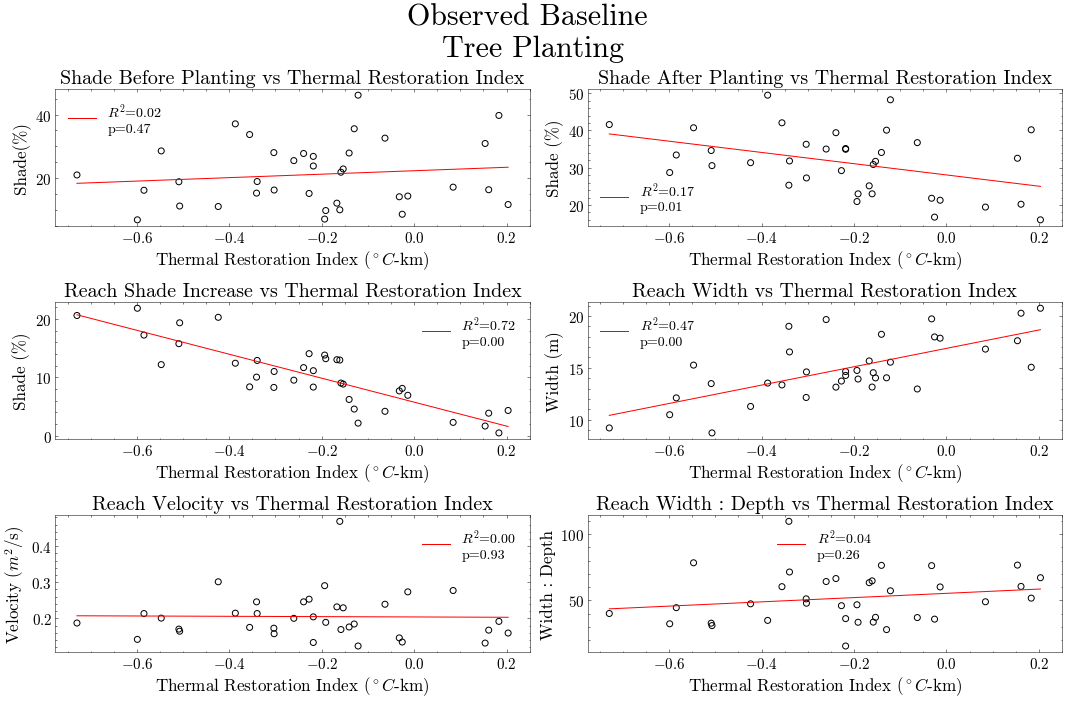

In [215]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# Assuming dif_df_dict contains your data

# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title+ ' vs Thermal Restoration Index', fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)
with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle('Observed Baseline \nTree Planting', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Baseline SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade Before Planting',  'Shade(%)', axs[0, 0])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Scenario SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade After Planting', 'Shade (%)', axs[0, 1])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Change in SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Shade Increase', 'Shade (%)', axs[1, 0])

    # Plot 2 (Assuming you have dif_df_dict2, dif_df_dict3, dif_df_dict4 for other data)
    # Adjust accordingly based on your actual data
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width', 'Width (m)', axs[1, 1])

    # Plot 3
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                dif_df_dict['Mean velocity'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Velocity', 'Velocity ($m{^2}$/s)', axs[2, 0])

    # Plot 4
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width:Depth'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width : Depth', 'Width : Depth', axs[2, 1])

    # Adjust layout
    plt.tight_layout()
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectivenessObserved_scatter.png', bbox_inches = 'tight', dpi = 300)
    # Show plot
    plt.show()

KeyError: 'Azimuth'

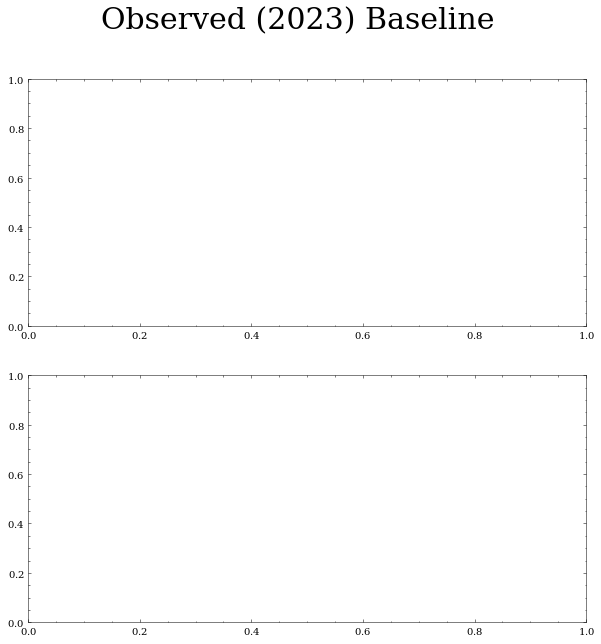

In [198]:
with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle('Observed (2023) Baseline', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Azimuth'].values,
                                 'Shade Increase', 'Reach Orientation \n(Deg fron North)', axs[0])
    #plot 2
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Shade Increase', 'Width (m)', axs[1])
    plt.tight_layout()
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreeRemovalEffectiveness_orientation.png', bbox_inches = 'tight', dpi = 300)


# Effectiveness maps
- map of effectiveness ranks
- map of degree kilometer change 

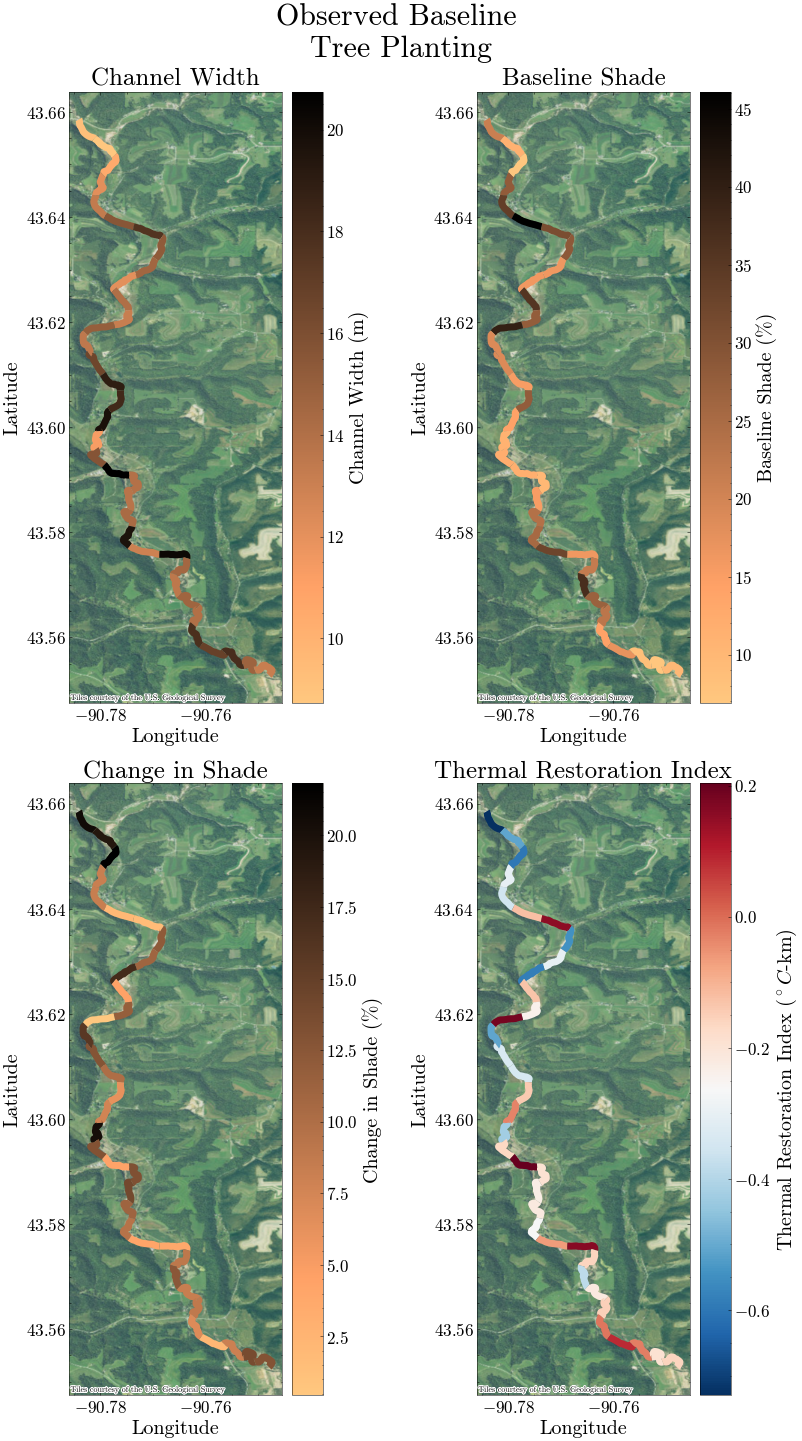

In [214]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots


# Define the original colormap
original_cmap = plt.cm.copper
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_width = [merged_gdf_dif['Width'].min(), merged_gdf_dif['Width'].max()]  
bounds_dif = [merged_gdf_dif['Baseline SR'].min(), merged_gdf_dif['Baseline SR'].max()]
bounds_changeSR = [merged_gdf_dif['Change in SR'].min(), merged_gdf_dif['Change in SR'].max()]

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Width'].min(), vmax=merged_gdf_dif['Width'].max())
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Baseline SR'].min(), vmax=merged_gdf_dif['Baseline SR'].max())
norm3 = mcolors.Normalize(vmin=merged_gdf_dif['Change in SR'].min(), vmax=merged_gdf_dif['Change in SR'].max())
norm4 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())

with plt.style.context(['science', 'no-latex']):
    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(2, 2, figsize=(40, 20), layout = 'compressed')
    fig.suptitle('Observed Baseline \nTree Planting', fontsize=30)

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(axes[0], crs=db_lonlat.crs)
    
    # Plot the first map
    ax1 = axes.flat[0]

    #ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm1)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=7, ax=ax1, norm=norm1)

    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 20)
    ax1.set_ylabel('Latitude', fontsize=20)
    ax1.set_title('Channel Width', fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=17)

    # Plot the second map
    ax2 = axes.flat[1]

    # ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=5, ax=axes[1], norm=norm2)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=7, ax=ax2, norm=norm2)

    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Baseline Shade', fontsize=25)
    ax2.set_xlabel('Longitude', fontsize=20)
    ax2.set_ylabel('Latitude', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=17)

    
    ax3 = axes.flat[2]

    # ax3 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=5, ax=axes[2], norm=norm3)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=7, ax=ax3, norm=norm3)

    ctx.add_basemap(ax3, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax3.set_title('Change in Shade', fontsize=25)
    ax3.set_xlabel('Longitude', fontsize=20)
    ax3.set_ylabel('Latitude', fontsize=20)
    ax3.tick_params(axis='both', which='major', labelsize=17)

    ax4 = axes.flat[3]

    # ax4 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=5, ax=axes[3], norm=norm4)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=7, ax=ax4, norm=norm4)

    ctx.add_basemap(ax4, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax4.set_title('Thermal Restoration Index', fontsize=25)
    ax4.set_xlabel('Longitude', fontsize=20)
    ax4.set_ylabel('Latitude', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    # Add colorbars for clarity
    # cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=axes[0], orientation='vertical')
    cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=ax1, orientation='vertical')
    cbar1.set_label('Channel Width (m)', fontsize=20)
    cbar1.ax.tick_params(axis='both', which='major', labelsize=17)


    cbar2 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm2, cmap=inverted_cmap), ax=ax2, orientation='vertical')
    cbar2.set_label('Baseline Shade (%)', fontsize=20)
    cbar2.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar3 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm3, cmap=inverted_cmap), ax=ax3, orientation='vertical')
    cbar3.set_label('Change in Shade (%)', fontsize=20)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar4 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm4, cmap=inverted_degree_cmap), ax=ax4, orientation='vertical')
    cbar4.set_label('Thermal Restoration Index (${^\circ}C$-km)', fontsize=20)
    cbar4.ax.tick_params(axis='both', which='major', labelsize=17)

    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mObservedPlantingEffectiveness.png', bbox_inches='tight', dpi=300)
    plt.show()


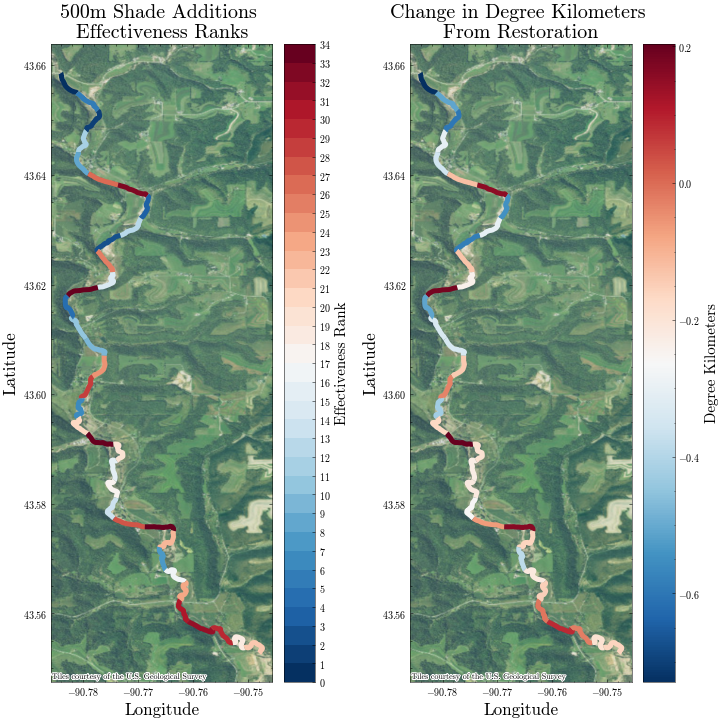

In [211]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots
# Define the original colormap
original_cmap = plt.cm.RdBu

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds = list(range(0, 35))  
bounds_dif = [merged_gdf_dif['Degree Kilometers'].min(), merged_gdf_dif['Degree Kilometers'].max()]

# Create a colormap norm with the defined boundaries
norm = mcolors.BoundaryNorm(bounds, inverted_cmap.N)

# Create a colormap norm with the defined boundaries for the second plot
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())
# norm2 = mcolors.LogNorm(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())

with plt.style.context(['science', 'no-latex']):

    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), layout = 'compressed')

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)

    # Plot the first map
    ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Effectiveness Rank', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm)
    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 17)
    ax1.set_ylabel('Latitude', fontsize = 17)
    ax1.set_title('500m Shade Additions \nEffectiveness Ranks', fontsize = 20)

    # Plot the second map
    ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_cmap, linewidth=5,ax=axes[1], norm=norm2)
    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Change in Degree Kilometers \nFrom Restoration', fontsize = 20)
    ax2.set_xlabel('Longitude', fontsize = 17)
    ax2.set_ylabel('Latitude', fontsize = 17)
    # Add colorbars for clarity
    cbar1 = plt.colorbar(mappable=axes[0].collections[0], ax=axes[0], orientation='vertical', boundaries=bounds, ticks=bounds)
    cbar1.set_label('Effectiveness Rank', fontsize = 15)

    cbar2 = plt.colorbar(mappable=axes[1].collections[0], ax=axes[1], orientation='vertical')
    cbar2.set_label('Degree Kilometers', fontsize = 15)
    plt.subplots_adjust(wspace=0)  # Adjust the width space between subplots

    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness_observedbaseline.png', bbox_inches = 'tight', dpi = 300)
    plt.show()


# Plotting the top 10 shade reaches implemented vs observed july temps
- i think i need to work on these scenarios - change morphology and landcover in 10 reaches , i think i only did 5


## In a new blank scenario run from july_monthly base,  adding the landcover and morphology attributes from the top 10 most effective reaches

In [210]:
# Finding the top 10 reaches from sorted effeciveness df

km_list = []
for index, row in dif_df_dict.head(10).iterrows():
    km_list.append(row['Model Start KM'])
km_list

[27.0, 26.0, 22.5, 23.5, 20.5, 26.5, 18.0, 13.0, 25.0, 19.5]

In [137]:
#folder of top 10 scenario i want to fill with reach by reach scenario data
for i in km_list:
    top10_source = f'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\ModelBaselines\\top10_restorationscenario'
    landcover_top10 = pd.read_csv(os.path.join(top10_source, 'inputs\WFK23_lcdata.csv'))
    morhpology_top10 = pd.read_csv(os.path.join(top10_source, 'inputs\WFK23_morphology.csv'))
    # loop to getlandcover files for the top 10 
    km_start = i
    km_end = km_start - .5
    #reach files
    reach_source_folder =  f'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\observedbaseline_shading2\\reach_{km_start}'
    landcover_reach = pd.read_csv(os.path.join(reach_source_folder, 'inputs\WFK23_lcdata.csv'))
    morphology_reach = pd.read_csv(os.path.join(reach_source_folder, 'inputs\WFK23_morphology.csv'))
    reach = landcover[(landcover['STREAM_KM'] <= km_start) & (landcover['STREAM_KM']>km_end)]
    print(reach)
    #loop through each row in reach and change landcover and morphology to forest
    for index, row in reach.iterrows():
        #write landcover from shade scenario to top10 scenario
        landcover_top10.loc[index, landcover_km.columns[8:48]] = landcover_reach.loc[index, landcover_reach.columns[8:48]]
        landcover_top10.to_csv(os.path.join(top10_source, 'inputs\WFK23_lcdata.csv'), index = False)

        # write morphology from shade landcover scenario to top10 scenario
        morhpology_top10.loc[index,morhpology_top10.columns[5]] = morphology_reach.loc[index,morphology_reach.columns[5]]
        morhpology_top10.to_csv(os.path.join(top10_source, 'inputs\WFK23_morphology.csv'), index = False)


   STREAM_ID  NODE_ID  STREAM_KM  LONGITUDE   LATITUDE     TOPO_W     TOPO_S  \
2        NaN      270       27.0 -90.784700  43.659290  11.179962   9.486133   
3        NaN      269       26.9 -90.784059  43.658572   5.904243   9.684961   
4        NaN      268       26.8 -90.783903  43.657690   3.955325  12.820139   
5        NaN      267       26.7 -90.783509  43.656848  13.284937  15.656237   
6        NaN      266       26.6 -90.783038  43.656025  28.381892  25.256129   

      TOPO_E  LC_T0_S0  LC_T1_S1  ...  ELE_T7_S1  ELE_T7_S2  ELE_T7_S3  \
2  12.773587         0         0  ...  291.50427  291.50427  292.36673   
3  10.507494         0         0  ...  288.15982  288.44537  288.37160   
4   7.181208         0         0  ...  287.15253  287.15253  287.22840   
5   3.436115         0         0  ...  286.50842  286.53244  286.53244   
6   4.377926         0         0  ...  286.45004  286.39337  286.39337   

   ELE_T7_S4  ELE_T7_S5  ELE_T8_S1  ELE_T8_S2  ELE_T8_S3  ELE_T8_S4  ELE_T

In [109]:
def mwmt(source_folder):
    model_tw_df = pd.read_csv(os.path.join(source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
    control_file = pd.read_csv(os.path.join(source_folder, 'HeatSource_Control.csv'))
    #fill in dates/times for index of model output
    cc_start = control_file.loc[7]['VALUE']
    cc_start = pd.to_datetime(cc_start)
    cc_end = control_file.loc[8]['VALUE']
    cc_end = pd.to_datetime(cc_end)
    hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive
    model_tw_df.columns = [float(col) for col in model_tw_df.columns]
    model_tw_df.index = hourly_index
    #mean & max july
    mean_daily_shade = allshade_tw_df.resample('D').mean()
    #adding MWMT
    mwmt = max_daily_shade.rolling(window=7).max()
    mwmt = shaded_mwmt.max()
    mwmt = pd.DataFrame(shaded_mwmt)
    return mwmt


## Calculating temp metrics for base and scenario models 

In [252]:
top10_scenario = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\top10_restorationscenario'
allshade_tw_df = pd.read_csv(os.path.join(top10_scenario, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
allshade_tw_df.columns = [float(col) for col in allshade_tw_df.columns]
obs_clip_day = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]

allshade_tw_df.index = pd.to_datetime(obs_clip_day.index)
#mean & max july
mean_daily_shade = allshade_tw_df.mean()
max_daily_shade = allshade_tw_df.max()

#adding MWAT

mean_daily_shade = allshade_tw_df.resample('D').mean()
shaded_mwat = mean_daily_shade.rolling(window=7).mean()
shaded_mwat = shaded_mwat.max()
shaded_mwat = pd.DataFrame(mean_daily_shade)

#adding MWMT
# shaded_mwmt = max_daily_shade.rolling(window=7).max()
# shaded_mwmt = shaded_mwmt.max()
shaded_mwmt = pd.DataFrame(max_daily_shade)
shaded_mean =  pd.DataFrame(mean_daily_shade)
shaded_max =  pd.DataFrame(max_daily_shade)

allshade_tw_df

,27.2,27.1,27.0,26.9,26.8,26.7,26.6,26.5,26.4,26.3,...,9.8,9.7,9.6,9.5,9.4,9.3,9.2,9.1,9.0,8.9
1970-01-01 00:00:00.000001525,20.817,20.8127,20.8120,20.8094,20.8095,20.8148,20.7462,20.8116,20.8129,20.8120,...,20.8120,20.8137,20.8128,20.8112,20.8117,20.8105,20.8124,20.8090,20.8105,20.8123
1970-01-01 00:00:00.000001526,20.484,20.4962,20.5033,20.4919,20.4888,20.5149,19.9353,19.9971,20.0458,20.1017,...,20.3161,20.3488,20.3768,20.3936,20.4126,20.4266,20.4454,20.4515,20.4649,20.4833
1970-01-01 00:00:00.000001527,20.150,20.1685,20.1819,20.1783,20.1817,20.2132,19.6463,19.6926,19.7185,19.7392,...,19.9816,19.9995,20.0123,20.0197,20.0293,20.0349,20.0460,20.0469,20.0563,20.0705
1970-01-01 00:00:00.000001528,19.841,19.8584,19.8720,19.8691,19.8741,19.9073,19.3532,19.4022,19.4301,19.4517,...,19.7454,19.7561,19.7621,19.7652,19.7705,19.7721,19.7791,19.7767,19.7822,19.7914
1970-01-01 00:00:00.000001529,19.484,19.5134,19.5369,19.5448,19.5581,19.5993,19.0585,19.1116,19.1424,19.1666,...,19.5787,19.5842,19.5850,19.5844,19.5860,19.5839,19.5871,19.5813,19.5832,19.5879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000002264,24.171,24.1475,24.0969,24.0400,23.9939,23.9988,23.1666,23.1697,23.1409,23.1037,...,21.9839,22.0150,22.0369,22.0560,22.0813,22.0957,22.1152,22.1231,22.1429,22.1684
1970-01-01 00:00:00.000002265,23.232,23.2826,23.2954,23.2982,23.3017,23.3686,22.6000,22.6612,22.6733,22.6725,...,21.5900,21.6086,21.6211,21.6293,21.6410,21.6475,21.6598,21.6603,21.6716,21.6879
1970-01-01 00:00:00.000002266,22.202,22.2714,22.3070,22.3270,22.3523,22.4569,21.7725,21.8863,21.9370,21.9715,...,21.2510,21.2557,21.2545,21.2507,21.2509,21.2481,21.2526,21.2455,21.2482,21.2558
1970-01-01 00:00:00.000002267,21.246,21.3256,21.3737,21.4080,21.4448,21.5512,20.9288,21.0485,21.1129,21.1658,...,21.0406,21.0346,21.0226,21.0114,21.0039,20.9933,20.9901,20.9760,20.9711,20.9691


In [226]:
monthly_observed_source_folder = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\july_monthly_extended'

upstreamconstant_df = pd.read_csv(os.path.join(monthly_observed_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 185))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip_day.index
# mean july temperature summary
upstreamconstant_modeled_mean = upstreamconstant_df.mean()
upstreamconstant_modeled_max = upstreamconstant_df.max()
upstreamconstant_modeled_max = pd.DataFrame(upstreamconstant_modeled_max)
upstreamconstant_modeled_mean = pd.DataFrame(upstreamconstant_modeled_mean)
upstreamconstant_modeled_mean

,0
27.2,20.065344
27.1,20.100311
27.0,20.143239
26.9,20.235305
26.8,20.308658
...,...
9.3,21.121668
9.2,21.139335
9.1,21.148291
9.0,21.170661


In [232]:
base_mwmt_df = pd.DataFrame(base_mwmt.max())
scenario_mwmt_df = pd.DataFrame(scenario_mwmt.max())
base_mwat_df = pd.DataFrame(base_mwat.max())
scenario_mwat_df = pd.DataFrame(scenario_mwat.max())

### Plotting scenario next to 2023 July baseline

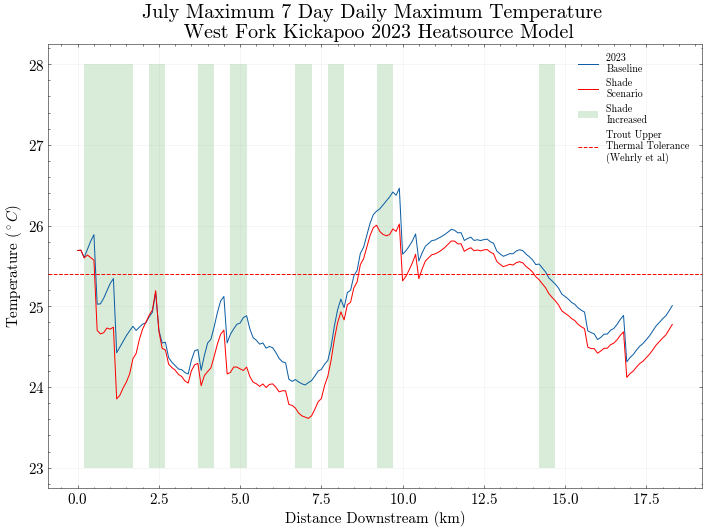

In [238]:
## July Mean

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(27.2 - base_mwmt_df.index, base_mwmt_df[0], label='2023 \nBaseline')
    plt.plot(27.2 - scenario_mwmt_df.index, scenario_mwmt_df[0], label='Shade \nScenario', color = 'red')
    for i in km_list:
        if i == 27.0:
            plt.fill_between([27.2 - i, 27.2 - (i-.5)], 23,28, color='green', edgecolor = None, alpha = .15, label = 'Shade \nIncreased')
        else:
            plt.fill_between([27.2 - i, 27.2 - (i-.5)], 23,28, color='green', edgecolor = None, alpha = .15)

    # dumb way to add a single label for shade additions
    # plt.fill_between([27.2 - 27.0, 27.2 - (27.0 -.5)], shaded_mean[0].min(),upstreamconstant_modeled_mean[0].max(), color='green', alpha = .15, label = 'Additional \nShading')

    x = np.linspace(-1,18.8,10)
    # plt.fill_between(x,25, 23.5, color = 'red', alpha = .2, label='Trout Upper Thermal Tolerance \n(Wehrly et al)')
    plt.ylabel('Temperature (${^\circ}C$)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')
    plt.axhline(y=25.4, linestyle='--', color='red', label='Trout Upper \nThermal Tolerance \n(Wehrly et al)')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    #plt.ylim(19, 21.5)
    # plt.xlim(-.5, 18.8)

    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 10)
    plt.title('July Maximum 7 Day Daily Maximum Temperature \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Top10JulyMaxTemp.png',bbox_inches='tight', dpi=300)
    plt.show()
    

In [241]:
scenario_mwmt_df

,0
27.2,25.691571
27.1,25.695486
27.0,25.599857
26.9,25.635243
26.8,25.604471
...,...
9.3,24.561243
9.2,24.605157
9.1,24.644657
9.0,24.708729


In [246]:
#TRI of 10 day change
x = 27.2- scenario_mwmt_df.index
y1 = scenario_mwmt_df[0]
y2 = base_mwmt_df[0]





# Compute absolute difference between the curves
abs_diff = np.abs(y1 - y2)
diff = y1 - y2

# Use Simpson's rule for numerical integration
area = simps(diff, x)
area

-4.565776666666666

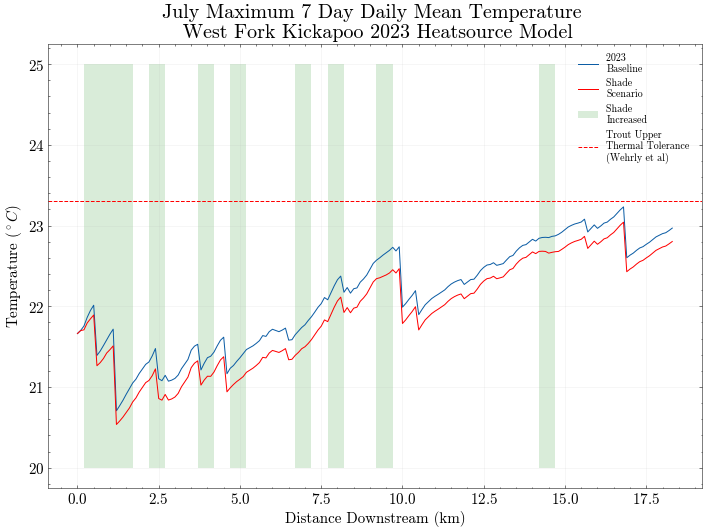

In [239]:
## July Mean

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(27.2 - base_mwat_df.index, base_mwat_df[0], label='2023 \nBaseline')
    plt.plot(27.2 - scenario_mwat_df.index, scenario_mwat_df[0], label='Shade \nScenario', color = 'red')
    for i in km_list:
        if i == 27.0:
            plt.fill_between([27.2 - i, 27.2 - (i-.5)], 20,25, color='green', edgecolor = None, alpha = .15, label = 'Shade \nIncreased')
        else:
            plt.fill_between([27.2 - i, 27.2 - (i-.5)], 20,25, color='green', edgecolor = None, alpha = .15)

    # dumb way to add a single label for shade additions
    # plt.fill_between([27.2 - 27.0, 27.2 - (27.0 -.5)], shaded_mean[0].min(),upstreamconstant_modeled_mean[0].max(), color='green', alpha = .15, label = 'Additional \nShading')

    x = np.linspace(-1,18.8,10)
    # plt.fill_between(x,25, 23.5, color = 'red', alpha = .2, label='Trout Upper Thermal Tolerance \n(Wehrly et al)')
    plt.ylabel('Temperature (${^\circ}C$)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')
    plt.axhline(y=23.3, linestyle='--', color='red', label='Trout Upper \nThermal Tolerance \n(Wehrly et al)')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    #plt.ylim(19, 21.5)
    # plt.xlim(-.5, 18.8)

    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 10)
    plt.title('July Maximum 7 Day Daily Mean Temperature \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Top10JulyMeanTemp.png',bbox_inches='tight', dpi=300)
    plt.show()

###  Difference between max and min temp differences, scenario vs baseline

In [40]:
max_diff_df = upstreamconstant_modeled_max - shaded_max
max_index = max_diff_df.idxmax()
max_value = max_diff_df.loc[max_index]

print("Index where the maximum value occurs:", max_index)
print("Value at that index:", max_value)
max_index-27.2

Index where the maximum value occurs: 0    26.1
dtype: float64
Value at that index:            0
26.1  0.7089


0   -1.1
dtype: float64

In [41]:
## Where did means cool the most
mean_diff_df = upstreamconstant_modeled_mean - shaded_mean
max_index = mean_diff_df.idxmax()
max_value = mean_diff_df.loc[max_index]

# print("Index where the maximum value occurs:", max_index)
# print("Value at that index:", max_value)
# max_index-27.2
model_value = upstreamconstant_modeled_mean.loc[max_index]
scenario_value = shaded_mean.loc[max_index]

scenario_value

,0
20.1,19.992953


In [57]:
#how much did the highest mean cool
max_mean_idx = upstreamconstant_modeled_mean.idxmax()
max_mean = upstreamconstant_modeled_mean.loc[max_mean_idx]
max_mean_cooled = shaded_mean.loc[max_mean_idx]
max_mean_cooled_dif = max_mean_cooled - max_mean
max_mean_idx


0    10.4
dtype: float64

In [43]:
max_max_idx = upstreamconstant_modeled_max.idxmax()
max_max= upstreamconstant_modeled_max.loc[max_max_idx]
max_max_cooled = shaded_max.loc[max_max_idx]
max_max_cooled_dif = max_max - max_max_cooled
max_max_cooled_dif


,0
17.3,0.4933


## Finding days above MWAT and MWMT Temp Thresholds

In [46]:
#MWaT BASELINE
obs_clip_day = obs_clip_day.set_index('datetime')

upstreamconstant_df.index = obs_clip_day.index
mean_daily_base = upstreamconstant_df.resample('D').mean()
# base_mwat = mean_daily_base.rolling(window=7).max()
base_mwat = mean_daily_base.rolling(window=7).mean()

basemwat_above_threshold = base_mwat.apply(lambda col: (col > 23.3).sum())
basemwat_above_threshold = pd.DataFrame(basemwat_above_threshold)
basemwat_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 23.3'}, inplace=True)

#MWMT BASELINE

#upstreamconstant_df.index = obs_clip_day.index
max_daily_base = upstreamconstant_df.resample('D').max()
base_mwmt = max_daily_base.rolling(window=7).mean()
basemwmt_above_threshold = base_mwmt.apply(lambda col: (col > 25.4).sum())
basemwmt_above_threshold = pd.DataFrame(basemwmt_above_threshold)
basemwmt_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 25.4'}, inplace=True)

basemwmt_above_threshold



,Days > 25.4
27.2,4
27.1,4
27.0,4
26.9,4
26.8,4
...,...
9.3,0
9.2,0
9.1,0
9.0,0


In [58]:
#MWAT Scenario

allshade_tw_df.index = obs_clip_day.index
#mean & max july
mean_daily_shade = allshade_tw_df.resample('D').mean()
scenario_mwat = mean_daily_shade.rolling(window=7).mean()
scenario_mwat
#scenario_mwat.rename(columns={'index': 'NODE_ID', 0 : 'MWAT'}, inplace=True)
scenariomwat_above_threshold = scenario_mwat.apply(lambda col: (col > 23.3).sum())
scenariomwat_above_threshold = pd.DataFrame(scenariomwat_above_threshold)
scenariomwat_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 23.3'}, inplace=True)

# #MWMT scenaroi

max_daily_shade = allshade_tw_df.resample('D').max()
scenario_mwmt = max_daily_shade.rolling(window=7).mean()
scenariomwmt_above_threshold = scenario_mwmt.apply(lambda col: (col > 25.4).sum())
scenariomwmt_above_threshold = pd.DataFrame(scenariomwmt_above_threshold)
scenariomwmt_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 25.4'}, inplace=True)

scenariomwmt_above_threshold

,Days > 25.4
27.2,4
27.1,4
27.0,4
26.9,4
26.8,3
...,...
9.3,0
9.2,0
9.1,0
9.0,0


## Plotting Days above Threshold Base and Scenario

In [76]:
#Difference in days above threshold MWMT 
MWMT_difference =  abs(scenariomwmt_above_threshold - basemwmt_above_threshold)
MWMT_daydifference = MWMT_difference[MWMT_difference['Days > 25.4']>2]
MWMT_daydifference.index = 27.2 - MWMT_daydifference.index
# len(MWMT_daydifference['Days > 25.4'])
MWMT_daydifference

,Days > 25.4
10.0,3
10.1,3


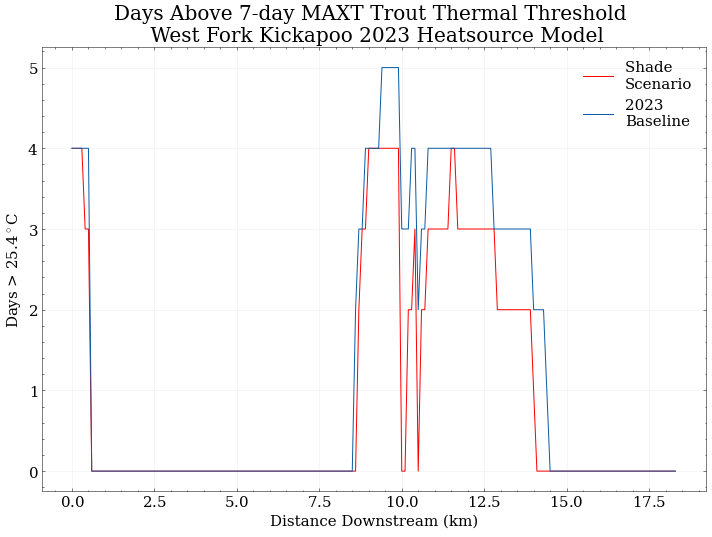

In [254]:
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(27.2-scenariomwmt_above_threshold.index, scenariomwmt_above_threshold['Days > 25.4'], label=f'Shade \nScenario', color = 'red')
    plt.plot(27.2-basemwmt_above_threshold.index, basemwmt_above_threshold['Days > 25.4'], label='2023 \nBaseline')
    plt.ylabel('Days > 25.4${^\circ}$C', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title('Days Above 7-day MAXT Trout Thermal Threshold \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.grid(alpha = .2)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\DaysAboveMWMTThreshold.png',bbox_inches='tight', dpi=300)

# axes[count-1].set_title(f'Hours above 22.3 - Shade added between {km_start} km and {km_end} km')
# axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
# axes[count-1].set_ylabel('Hours')  # Replace 'Y Label' with appropriate label


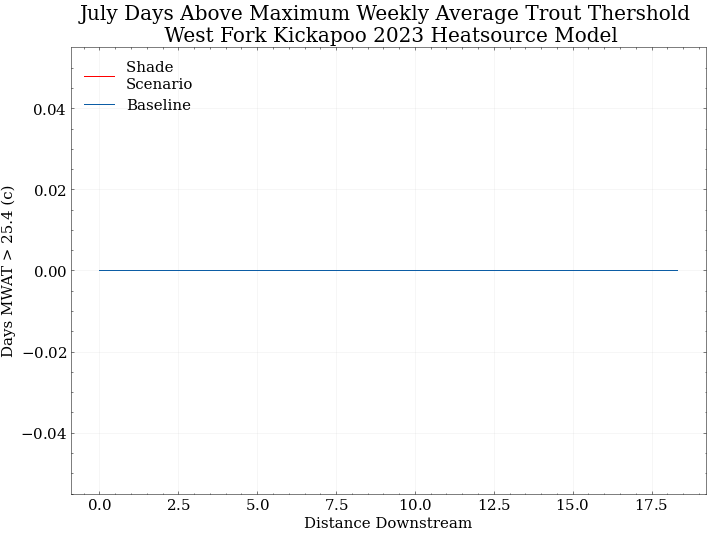

In [284]:
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(27.2-scenariomwat_above_threshold.index, scenariomwat_above_threshold['Days > 23.3'], label=f'Shade \nScenario', color = 'red')
    plt.plot(27.2-basemwat_above_threshold.index, basemwat_above_threshold['Days > 23.3'], label='Baseline')
    plt.ylabel('Days MWAT > 25.4 (c)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.title('July Days Above Maximum Weekly Average Trout Thershold \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.grid(alpha = .2)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\ModelOutputs\DaysAboveMWATThreshold.png',bbox_inches='tight', dpi=300)

# axes[count-1].set_title(f'Hours above 22.3 - Shade added between {km_start} km and {km_end} km')
# axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
# axes[count-1].set_ylabel('Hours')  # Replace 'Y Label' with appropriate label


## Plotting a map down here possibly? Need Node shapefile though

In [ ]:
nodes = gpd.read_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/shp/restoration_reaches500m.shp')

MWAT_threshold = pd.merge(merged_gdf_dif, MWMT_difference, left_on='row', right_index = True, how='left')
